In [1]:
from pymongo import MongoClient
import pymongo
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.signal as sig
from IPython import display
from IPython.parallel import Client
import sys
import numbapro

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
client = MongoClient()
db = client.VentDyssynchrony_db
test_data = db.TestData_collection
breath_data = db.BreathData_collection


In [3]:
ipclient = Client()
print (ipclient.ids)
#ipview = ipclient[:]
ipview = ipclient.load_balanced_view()

TimeoutError: Hub connection request timed out

## Genereates Random Selection of DB

In [7]:
'''
import random

#db.drop_collection('TestData_collection')

results_db = breath_data.aggregate([{'$group':{
                                        '_id':{'ID':'$patientID','file':'$file_name'}, 
                                        'n':{'$max':'$breath_number'}}}])
results = list(results_db)

count = 0
while count < 10000:
    count = count + 1
    
    if count % 1000 == 0: print(count)
    
    temp = None
    while (type(temp) is type(None)):
        pick_file = random.randrange(len(results))
        n = random.randrange(results[pick_file]['n'])
        temp = breath_data.find_one({'patientID': results[pick_file]['_id']['ID'], 
                                     'file_name':results[pick_file]['_id']['file'], 
                                     'breath_number':n, 'vent_settings.vent_mode':'APVCMV'})
        
    while (temp['characteristics']['breath_time'] > 8) or (temp['vent_settings']['vent_mode'] != 'APVCMV') or (type(temp) is type(None)):
        #print(temp['characteristics']['breath_time'],temp['vent_settings']['vent_mode'], temp2['characteristics']['breath_time'], count)
        pick_file = random.randrange(len(results))
        n = random.randrange(results[pick_file]['n'])
        temp = breath_data.find_one({'patientID': results[pick_file]['_id']['ID'], 
                                     'file_name':results[pick_file]['_id']['file'], 
                                     'breath_number':n, 'vent_settings.vent_mode':'APVCMV'})
        
        while (type(temp) is type(None)):
            pick_file = random.randrange(len(results))
            n = random.randrange(results[pick_file]['n'])
            temp = breath_data.find_one({'patientID': results[pick_file]['_id']['ID'], 
                                         'file_name':results[pick_file]['_id']['file'], 
                                         'breath_number':n, 'vent_settings.vent_mode':'APVCMV'})

       
    try:
        temp2 = breath_data.find_one({'patientID': results[pick_file]['_id']['ID'], 'file_name':results[pick_file]['_id']['file'], 'breath_number':n+1})
        if temp['characteristics']['breath_time'] <= 8 and temp['vent_settings']['vent_mode'] == 'APVCMV':
            temp['analysis'] = {'couplet':False}
            temp2['analysis'] = {'couplet':True}
            test_data.insert_one(temp)
            test_data.insert_one(temp2)
            
        else:
            count = count-1 
            print(temp['characteristics']['breath_time'],temp['vent_settings']['vent_mode'], temp2['characteristics']['breath_time'], count)

        
    except:
        count = count -1
'''

"\nimport random\n\n#db.drop_collection('TestData_collection')\n\nresults_db = breath_data.aggregate([{'$group':{\n                                        '_id':{'ID':'$patientID','file':'$file_name'}, \n                                        'n':{'$max':'$breath_number'}}}])\nresults = list(results_db)\n\ncount = 0\nwhile count < 10000:\n    count = count + 1\n    \n    if count % 1000 == 0: print(count)\n    \n    temp = None\n    while (type(temp) is type(None)):\n        pick_file = random.randrange(len(results))\n        n = random.randrange(results[pick_file]['n'])\n        temp = breath_data.find_one({'patientID': results[pick_file]['_id']['ID'], \n                                     'file_name':results[pick_file]['_id']['file'], \n                                     'breath_number':n, 'vent_settings.vent_mode':'APVCMV'})\n        \n    while (temp['characteristics']['breath_time'] > 8) or (temp['vent_settings']['vent_mode'] != 'APVCMV') or (type(temp) is type(None)):\n      

## Open Test Data and Unpack into DataFrame 

In [3]:
test_data.find({'validation.raw':{'$exists':1}}).count()

1804

In [4]:
data = test_data.find({'validation.raw':{'$exists':1}})
breath_df = pd.DataFrame(list(data))

In [5]:
breath_df.columns

Index(['_id', 'analysis', 'breath_number', 'characteristics', 'characteristics:ds_vol', 'data_frame', 'end_time', 'file_name', 'location', 'patientID', 'start_time', 'validation', 'vent_settings'], dtype='object')

In [6]:
unpack_col = []
def unpack(breath, unpack_col = unpack_col):
    for col in unpack_col:      
        key_names = set()
        keys = set()
        
        try:
            keys = breath[col].apply(lambda x: set(x.keys()) if isinstance(x, dict) else set())
        except:
            print(sys.exc_info()[0])
            
        
        try:
            for items in keys:
                key_names.update(items)
        except:
            print(sys.exc_info()[0])
            print(keys)

        try:
            for key in key_names:
                breath[col +':'+ key] = breath[col].apply(lambda x: x[key] if (isinstance(x, dict) and (key in x)) else np.nan)
            breath.drop(col, inplace=True, axis=1)
        except:
            print(sys.exc_info()[0])
            print('last', key, key_names)
    
    return breath

breath_df = unpack(breath_df, unpack_col = ['characteristics', 'data_frame', 'vent_settings', 'analysis', 'validation'])
breath_df.drop(['data_frame:DateTime', 'location'], inplace=True, axis=1)
breath_df.sort(columns = 'start_time', inplace=True)
breath_df.reset_index(inplace=True, drop=True)
breath_df.reset_index(inplace=True, drop=False)
breath_df.rename(columns={'index':'row_id'}, inplace=True)
breath_df['characteristics:ds_vol'] = np.nan

In [7]:
breath_df.columns

Index(['row_id', '_id', 'breath_number', 'characteristics:ds_vol', 'end_time', 'file_name', 'patientID', 'start_time', 'characteristics:breath_time', 'characteristics:min_exp_flow', 'characteristics:max_pressure', 'characteristics:peak_insp_flow', 'characteristics:exp_time', 'characteristics:max_vol', 'characteristics:end_insp_vol', 'characteristics:min_vol', 'characteristics:max_flow', 'characteristics:peak_pressure', 'characteristics:min_flow', 'characteristics:insp_time', 'characteristics:min_pressure', 'data_frame:Status', 'data_frame:Time', 'data_frame:Flow', 'data_frame:Paw', 'data_frame:Volume', 'vent_settings:compliance', 'vent_settings:reference_doc', 'vent_settings:load_errors', 'vent_settings:file_name', 'vent_settings:distance', 'vent_settings:te', 'vent_settings:vent_mode', 'vent_settings:p_plat', 'vent_settings:PEEP', 'vent_settings:set_VT', 'vent_settings:leak', 'vent_settings:ie', 'vent_settings:ramp', 'vent_settings:p_peak', 'vent_settings:p_mean', 'vent_settings:FiO2'

In [8]:
breath_df['characteristics:breath_time'][breath_df['analysis:couplet'] == False].describe()

count    1804.000000
mean        2.653390
std         0.765043
min         0.128000
25%         2.272000
50%         2.816000
75%         3.168000
max         4.416000
Name: characteristics:breath_time, dtype: float64

In [9]:
breath_df['characteristics:breath_time'].describe()

count    1804.000000
mean        2.653390
std         0.765043
min         0.128000
25%         2.272000
50%         2.816000
75%         3.168000
max         4.416000
Name: characteristics:breath_time, dtype: float64

In [10]:
breath_df.columns

Index(['row_id', '_id', 'breath_number', 'characteristics:ds_vol', 'end_time', 'file_name', 'patientID', 'start_time', 'characteristics:breath_time', 'characteristics:min_exp_flow', 'characteristics:max_pressure', 'characteristics:peak_insp_flow', 'characteristics:exp_time', 'characteristics:max_vol', 'characteristics:end_insp_vol', 'characteristics:min_vol', 'characteristics:max_flow', 'characteristics:peak_pressure', 'characteristics:min_flow', 'characteristics:insp_time', 'characteristics:min_pressure', 'data_frame:Status', 'data_frame:Time', 'data_frame:Flow', 'data_frame:Paw', 'data_frame:Volume', 'vent_settings:compliance', 'vent_settings:reference_doc', 'vent_settings:load_errors', 'vent_settings:file_name', 'vent_settings:distance', 'vent_settings:te', 'vent_settings:vent_mode', 'vent_settings:p_plat', 'vent_settings:PEEP', 'vent_settings:set_VT', 'vent_settings:leak', 'vent_settings:ie', 'vent_settings:ramp', 'vent_settings:p_peak', 'vent_settings:p_mean', 'vent_settings:FiO2'

## Analysis of Test Data 

###Define Some Basic Functions

In [24]:
p_or_f = 'flow'
s = 1
start = 0
end = 1
n_max = np.array([0])
n_min = np.array([0])

# plots a breath
def plotted(analysis_df, n_max, n_min, **kwargs):
        analysis_df.plot(y=['flow','paw', 'smooth', 'volume'], sharex=True, secondary_y=['volume'])
       
        for x in np.nditer(n_max):
            try:
                plt.axvline(x=analysis_df['time'].iloc[int(x)])
            except:
                print('plt', sys.exc_info()[0])

        for x in np.nditer(n_min):
            try:
                plt.axvline(x=analysis_df['time'].iloc[int(x)], color='r')
            except:
                print('plt', sys.exc_info()[0])
        
        len_at_end = analysis_df[analysis_df.status == 1].shape[0]
        status_df = analysis_df[:len_at_end - 3]
        tempx = status_df['time'].values[-1]
        #plt.axvline(x=tempx, color ='g')

# makes df for analysis
def make_analysis_df(row, p_or_f=p_or_f):
    analysis_df = pd.DataFrame({'flow': np.array(row['data_frame:Flow']),'paw':np.array(row['data_frame:Paw']), 'status':np.array(row['data_frame:Status']), 
                                'time':np.array(row['data_frame:Time']), 'volume':np.array(row['data_frame:Volume']), 'breath_num':row['breath_number']})
    analysis_df.set_index('time', inplace=True, drop=False)
    analysis_df['status'] = analysis_df['status'].apply(lambda x: 1 if x>0 else 0)
    
    try:
        smoothed_array = sig.savgol_filter(analysis_df[p_or_f].values, window_length=7, polyorder=2)
        analysis_df['smooth'] =  pd.Series(smoothed_array, index=analysis_df.index)
    except:
        analysis_df['smooth'] =  analysis_df[p_or_f]
        print('make', sys.exc_info()[0])
    
    return analysis_df

# find min.max for np array
def find_min_max(analysis_df, p_or_f, s=s, start=start, end=end):
    #status_df = analysis_df[analysis_df.status == s]  
    
    if s==1:
        len_at_end = analysis_df[analysis_df.status == 1].shape[0]
        status_df = analysis_df[:len_at_end + 3]
    else:
        len_at_end = analysis_df[analysis_df.status == 1].shape[0]
        status_df = analysis_df[len_at_end - 3:-1]
        
    if status_df[p_or_f].values.size == 0:
        return np.array(np.nan), np.array(np.nan), np.array(np.nan)
    
    init = int(status_df[p_or_f].shape[0]*start)
    fin = int(status_df[p_or_f].shape[0]*end)
    mid = int(status_df[p_or_f].shape[0]*0.5)
       
    if fin - init < 10:
        fin = init + 10
    try:
        n_max = np.array(sig.find_peaks_cwt(status_df['smooth'].values[init:fin], np.arange(3,20), noise_perc=20))
        n_min = np.array(sig.find_peaks_cwt((status_df['smooth'].values[init:fin])*-1, np.arange(3,20), noise_perc=20))
    except:
        n_max = np.array([])
        n_min = np.array([])
        print(init, fin, status_df[p_or_f])
        print(sys.exc_info()[0])

    #n_max = np.array(sig.find_peaks_cwt(status_df['smooth'][init:fin].values, np.arange(2,10), noise_perc=20))
    #n_min = np.array(sig.find_peaks_cwt(status_df['smooth'][init:fin].values*-1, np.arange(2,10), noise_perc=20))
             
    if n_max.size < 2:
        n_max = np.array(sig.argrelmax(status_df['smooth'].values[init:fin], order=1, mode='clip')[0])
        
    if n_min.size < 1:
        n_min = np.array(sig.argrelmin(status_df['smooth'].values[init:fin], order=1, mode='clip')[0])

    if n_max.size < 2:
        n_max = np.array([np.argmax(status_df['smooth'].values[init:fin])])
    
    if n_min.any() == 0:
        n_min = np.array([np.argmin(status_df['smooth'].values[init:fin])])

    if s == 0:
        n_max = n_max + analysis_df[analysis_df.status == 1].shape[0] + init - 3
        n_min = n_min + analysis_df[analysis_df.status == 1].shape[0] + init - 3
    
    return status_df, n_max, n_min

### Find DS Breaths

In [14]:
@numbapro.vectorize([numbapro.boolean(numbapro.float64, numbapro.float64)])
def ds(x, y):
    if (x < 0.75) & (y > 50): return True
    else: return False

In [15]:
breath_df['analysis:ds_mid'] = ds(breath_df['characteristics:exp_time'].values, breath_df['characteristics:end_insp_vol'].values)

10000 loops, best of 3: 187 µs per loop


In [45]:
breath_df['analysis:ds_mid'].value_counts()

False    1594
True      210
dtype: int64

### Find Post-DS Breaths

In [88]:
def find_post_ds(row, breath_df=breath_df):
    current_row = row['row_id']
    next_row = current_row + 1
    ds_vol = np.nan
    
    try:
        x = breath_df['characteristics:max_vol'].ix[next_row]
    except:
        return False, ds_v
        
    #print (row.patientID, breath_df.patientID.loc[next_row], row.breath_number, breath_df.breath_number.loc[next_row]) 
    
    try:
        if (breath_df.patientID.ix[next_row] == row.patientID) and (breath_df.breath_number.ix[next_row] == row.breath_number+1):
            ds_vol = breath_df['characteristics:end_insp_vol'].ix[current_row] + breath_df['characteristics:max_vol'].ix[next_row]
            return True, ds_vol
        else:
            return False, ds_vol
    except:
        print(sys.exc_info()[0])
        return False, np.nan

In [89]:
breath_df['analysis:pds'], breath_df['characteristics:ds_vol'] = breath_df[(breath_df['analysis:ds_spec'] == True) & (breath_df['analysis:couplet'] == False)].apply(find_post_ds, breath_df=breath_df, axis=1)
breath_df['analysis:pds'].value_counts()

NameError: ("name 'np_nan' is not defined", 'occurred at index 1803')

### Find IE Breaths

In [12]:
def max_min(concave_index, analysis_df, max_or_min):
    count = 0
    end = []
    start = [concave_index[0]]
    while count < concave_index.size -3:
        if concave_index[count] + 1 < concave_index[count+1] and concave_index[count] + 2 != concave_index[count+2] and concave_index[count] + 3 != concave_index[count+3]:
            start.append(concave_index[count+1])
            end.append(concave_index[count])
        count = count + 1
    start_end = list(zip(start, end))
    
    n_index = np.array([])
    for items in start_end:
        if items[1]-items[0] >= 3:
            if max_or_min == 'max':
                n_index = np.append(n_index, np.array(np.argmax(analysis_df['smooth'].values[items[0]:items[1]])+items[0]))
            elif max_or_min == 'min':
                n_index = np.append(n_index, np.array(np.argmin(analysis_df['smooth'].values[items[0]:items[1]])+items[0]))


    return n_index


In [14]:
def find_ie(row, p_or_f=p_or_f):
    if row['characteristics:max_vol'] < 100:
        return True
    
    if row['characteristics:exp_time'] < 0.75:
        return False
    
    analysis_df = make_analysis_df(row,  p_or_f=p_or_f)
    
    n_max = np.array([])
    n_min = np.array([])
    
    exp_start = analysis_df[analysis_df.status == 1].shape[0]
    exp_end = analysis_df.shape[0]
    search_start = int((exp_end-exp_start)*0.3 + exp_start)
    search_delta = exp_end - search_start
    
    analysis_df['diff1'] = analysis_df['smooth'].diff()
    analysis_df['diff2'] = analysis_df['diff1'].diff()

    concave_down_index = np.ravel(np.argwhere(analysis_df['diff2'].values < 0))
    concave_up_index = np.ravel(np.argwhere(analysis_df['diff2'].values > 0))
            
    n_max = max_min(concave_down_index, analysis_df, 'max')
    n_min = max_min(concave_up_index, analysis_df, 'min')

    n_max = n_max[n_max >= search_start]
    n_min = n_min[n_min >= search_start]   

    if n_max.size == 0 or n_min.size == 0:
        return False
    if n_max.size >= 1 and n_min.size >=1:
        try:
            for items in n_max:
                if items + 4 < analysis_df['smooth'].shape[0] -1:
                    if analysis_df['smooth'].iloc[items] > analysis_df['smooth'].iloc[items-4:items+4].mean() *0.8:
                        return True
                if analysis_df['smooth'].iloc[items] > analysis_df['smooth'].iloc[n_min[-1]] *0.9:
                    if items < n_min[-1]:
                        return True
                if n_min[n_min < items].size > 0:
                    if analysis_df['smooth'].iloc[items] > analysis_df['smooth'].iloc[n_min[n_min < items][-1]] *0.5:
                        if np.absolute(items - n_min[n_min < items][-1]) < 3:
                            return True
        except:
            print('ie', n_max, n_min, analysis_df['smooth'].shape)
            print(sys.exc_info()[0])
  
    return False

In [ ]:
breath_df['analysis:ie'] = breath_df.apply(find_ie, p_or_f='flow', axis=1)
breath_df['analysis:ie'].value_counts()

### Find Flow Limited Breaths 

In [78]:
def find_limited(row, p_or_f=p_or_f):
    analysis_df = make_analysis_df(row, p_or_f)

    n_max = np.array([])
    n_min = np.array([])
    
    exp_start = analysis_df[analysis_df.status == 1].shape[0]
    
    analysis_df['diff1'] = analysis_df['smooth'].diff()
    analysis_df['diff2'] = analysis_df['diff1'].diff()
    
    concave_down_index = np.ravel(np.argwhere(analysis_df['diff2'].values < 0))
    concave_up_index = np.ravel(np.argwhere(analysis_df['diff2'].values > 0))
            
    if concave_down_index.size > 0:
        n_max = max_min(concave_down_index, analysis_df, 'max')
    if concave_up_index.size > 0:
        n_min = max_min(concave_up_index, analysis_df, 'min')

    n_max = n_max[n_max <= exp_start+3]
    n_min = n_min[(n_min >= int(exp_start*0.1)) & (n_min <= exp_start-1)]

    if n_max.size == 0 or n_min.size == 0:
        return False
    
    if n_max[-1]/exp_start < 0.75:
        n_max = np.append(n_max, np.argmax(analysis_df[p_or_f].values[int(exp_start*0.75):])+int(exp_start*0.75))
    if n_min[0]/exp_start > 0.8:
        new_min = np.argmin(analysis_df[p_or_f].values[int(exp_start*0.25):int(exp_start*0.75)])+int(exp_start*0.25)
        n_min = np.append(np.array(new_min), n_min)
    
    ps = 0.2
    ptp = 1.025
    if (n_max.size >= 2) and (n_min.size >= 1):
        if n_max[0] < n_min[-1] < n_max[-1]:
            if (n_max[-1] - n_max[0])/exp_start > ps:
                if analysis_df['smooth'].iloc[n_max[0]] > 5 and analysis_df['smooth'].iloc[n_max[-1]] > 5:
                    if (analysis_df[p_or_f].iloc[n_min[-1]] * ptp < analysis_df[p_or_f].iloc[n_max[0]]) or (analysis_df[p_or_f].iloc[n_min[-1]] * ptp < analysis_df[p_or_f].iloc[n_max[-1]]): 
                        if (analysis_df[p_or_f].iloc[n_min[-1]] <= analysis_df[p_or_f].iloc[n_max[0]]) and (analysis_df[p_or_f].iloc[n_min[-1]] <= analysis_df[p_or_f].iloc[n_max[-1]]):
                            #print(n_max[0], n_min[0], n_max[-1])
                            #print(analysis_df[p_or_f].iloc[n_max[0]], analysis_df[p_or_f].iloc[n_min[0]], analysis_df[p_or_f].iloc[n_max[-1]])
                            #plotted(analysis_df, n_max, n_min)
                            return True
        if n_max[0] < n_min[0] < n_max[1]:
            if (n_max[1] - n_max[0])/exp_start > ps:
                if analysis_df['smooth'].iloc[n_max[0]] > 5 and analysis_df['smooth'].iloc[n_max[1]] > 5:
                    if (analysis_df[p_or_f].iloc[n_min[0]] * ptp < analysis_df[p_or_f].iloc[n_max[0]]) or (analysis_df[p_or_f].iloc[n_min[0]] * ptp < analysis_df[p_or_f].iloc[n_max[1]]): 
                        if (analysis_df[p_or_f].iloc[n_min[0]] <= analysis_df[p_or_f].iloc[n_max[0]]) and (analysis_df[p_or_f].iloc[n_min[0]] <= analysis_df[p_or_f].iloc[n_max[1]]):
                            return True

    # Find Late Peaks
    if n_max.size == 1 and n_max/exp_start > 0.6 and p_or_f == 'flow':
        if np.less(analysis_df['diff1'].values[:exp_start], 7).all():
            #plotted(analysis_df, n_max, n_min)
            #print(derivated)
            return True

    # Find if No Sustained Rise
    if np.average(analysis_df[analysis_df.status ==1][p_or_f]) < np.average(analysis_df[analysis_df.status ==0][p_or_f]):
        #plotted(analysis_df, n_max, n_min)
        return True 
    
   
    return False

In [79]:
breath_df['analysis:fl'] = breath_df.apply(find_limited, p_or_f='flow', axis=1)
breath_df['analysis:fl'].value_counts()

make <class 'TypeError'>
make <class 'TypeError'>


False    1421
True      383
dtype: int64

### Find Pressure Limited Breaths (Sucking) 

In [80]:
breath_df['analysis:pl'] = breath_df.apply(find_limited, p_or_f='paw', axis=1)
breath_df['analysis:pl'].value_counts()

make <class 'TypeError'>
make <class 'TypeError'>


False    1402
True      402
dtype: int64

### Find Premature Vent Termination

In [98]:
def find_pvt(row, p_or_f):
    analysis_df = make_analysis_df(row, p_or_f=p_or_f)
    
    len_at_end = analysis_df[analysis_df.status == 1].shape[0]
    status_df = analysis_df[len_at_end - 3:-1]

    if status_df.shape[0] == 0:
        print('nostatus')
        return False
    
    n_max = np.array([])
    n_min = np.array([])   
    
    try:
        init = int(status_df['smooth'].shape[0]*0)
        fin = int(status_df['smooth'].shape[0]*0.1+1)
        n_max = np.append(n_max, np.array([np.argmax(status_df['smooth'].values[init:fin])+init]))
        n_min = np.append(n_min, np.array([np.argmin(status_df['smooth'].values[init:fin])+init]))

        fin = int(status_df['smooth'].shape[0]*0.35+1)
        if n_min[0] +1 < status_df.shape[0]:
            n_max = np.append(n_max, np.array([np.argmax(status_df['smooth'].values[n_min[0]+1:fin])+n_min[0]+1]))
            n_min = np.append(n_min, np.array([np.argmin(status_df['smooth'].values[n_min[0]+1:fin])+n_min[0]+1]))
        
        if n_max[-1] < int(status_df.shape[0] *0.1):
            return False
        
        n_max = n_max + analysis_df[analysis_df.status == 1].shape[0] + init - 3
        n_min = n_min + analysis_df[analysis_df.status == 1].shape[0] + init - 3
        
        
    except:
        print(n_max, n_min, init, fin, status_df.shape)
        print('try', sys.exc_info()[0])
    
    try:
        if n_max[-1] >= n_min[-1] and n_max.size > 1:
            if n_max[-1] +3 < analysis_df.shape[0]:
                init = n_max[-1]+3
                fin = int(analysis_df[p_or_f].shape[0]-1)
                n_min = np.append(n_min, np.array([np.argmin(analysis_df['smooth'].values[n_max[-1]:])+n_max[-1]+3]))
    except:
        print(n_max, n_min, init, fin, status_df.shape)
        print('try2', sys.exc_info()[0])
  
    n_max = np.unique(n_max)
    n_min = np.unique(n_min)
    
    if n_max.size == 0 or n_min.size == 0:
        #plotted(analysis_df, status_df, n_max, n_min)
        #plt.title('failed to find max' + ' ,' +str(n_max))
        return False

    try:
        # Find Early Peaks following first Min and Increased at Least 10% from Min
        if n_max.size >= 1 and n_min.size >=2:    
            if n_min[-2] < n_max[-1] < n_min[-1]:
                if analysis_df[p_or_f].iloc[n_max[-1]] < 20:
                    if analysis_df[p_or_f].iloc[n_max[-1]]> analysis_df[p_or_f].iloc[n_min[-1]]:
                         if analysis_df[p_or_f].iloc[n_max[-1]] > analysis_df[p_or_f].iloc[n_min[-2]]:
                            #plotted(analysis_df, n_max, n_min)
                            return True
    except IndexError:
        n_min[-1] = analysis_df.shape[0] -1
        if n_max.size >= 1 and n_min.size >=2:    
            if n_min[-2] < n_max[-1] < n_min[-1]:
                if analysis_df[p_or_f].iloc[n_max[-1]] < 20:
                    if analysis_df[p_or_f].iloc[n_max[-1]] *1.1 > analysis_df[p_or_f].iloc[n_min[-1]]:
                         if analysis_df[p_or_f].iloc[n_max[-1]] *1.1 > analysis_df[p_or_f].iloc[n_min[-2]]:
                            #plotted(analysis_df, n_max, n_min)
                            return True
    except:
        print(n_max, n_min, analysis_df.shape)
        print('pvt', sys.exc_info()[0])
        return False

    
    return False

breath_df['analysis:pvt'] = breath_df.apply(find_pvt, p_or_f='flow', axis=1)
breath_df['analysis:pvt'].value_counts()

[ 0.] [ 0.] 0 1 (2, 7)
try <class 'ValueError'>
make <class 'TypeError'>
[ 0.] [ 0.] 0 1 (2, 7)
try <class 'ValueError'>
make <class 'TypeError'>
[ 0.] [ 0.] 0 1 (2, 7)
try <class 'ValueError'>


False    1448
True      356
dtype: int64

### Summary of Data 

In [81]:
summary_df = breath_df[['_id', 'analysis:ds_spec','analysis:ds_mid', 'analysis:ds_sens', 
                        'analysis:pds', 'analysis:ie', 'analysis:fl', 'analysis:pl', 'analysis:pvt', 'analysis:couplet', 'characteristics:ds_vol']]


for i in ['analysis:ds_spec','analysis:ds_mid', 'analysis:ds_sens', 
          'analysis:pds', 'analysis:ie', 'analysis:fl', 'analysis:pl', 'analysis:pvt']:
    print(i, '\n', summary_df[i].value_counts())

analysis:ds_spec 
 False    1601
True      203
dtype: int64
analysis:ds_mid 
 False    1594
True      210
dtype: int64
analysis:ds_sens 
 False    1590
True      214
dtype: int64
analysis:pds 
 False    244
dtype: int64
analysis:ie 
 False    1461
True      343
dtype: int64
analysis:fl 
 False    1421
True      383
dtype: int64
analysis:pl 
 False    1402
True      402
dtype: int64
analysis:pvt 
 False    1448
True      356
dtype: int64


### Save to Database

In [82]:
summary_df.rename(columns={'analysis:ds_spec':'ds_spec','analysis:ds_mid':'ds_mid', 'analysis:ds_sens':'ds_sens', 
          'analysis:pds':'pds', 'analysis:ie':'ie', 'analysis:fl':'fl', 'analysis:pl':'pl', 'analysis:pvt':'pvt', 'analysis:couplet':'couplet'}, inplace=True)
summary_df.head()

,_id,ds_spec,ds_mid,ds_sens,pds,ie,fl,pl,pvt,couplet,characteristics:ds_vol
0,P100\WF0\2014-04-21 13:01:28,False,False,False,False,True,False,False,False,False,NaN
1,P100\WF2\2014-04-21 13:01:33,False,False,False,NaN,True,True,False,True,False,NaN
2,P100\WF5\2014-04-21 17:36:33,False,False,False,NaN,True,True,False,False,False,NaN
3,P100\WF6\2014-04-21 17:36:36,False,False,False,NaN,True,False,False,False,False,NaN
4,P100\WF2\2014-04-21 17:36:59,False,False,False,NaN,True,False,False,True,False,NaN


In [83]:
summary_dict = summary_df.to_dict(orient='records')

for items in summary_dict:
    test_data.update_one({'_id':items['_id']}, {'$set':{'analysis.ds_spec':items['ds_spec'],'analysis.ds_mid':items['ds_mid'],
                                               'analysis.ds_sens':items['ds_sens'],'analysis.pds':items['pds'],'analysis.ie':items['ie'],
                                               'analysis.fl':items['fl'],'analysis.pl':items['pl'],'analysis.pvt':items['pvt'],
                                               'analysis.couplet':items['couplet'], 'characteristics:ds_vol':items['characteristics:ds_vol']}})

In [66]:
test_data.find_one({'_id':'P100\\WF0\\2014-04-21 13:01:28'})

{'_id': 'P100\\WF0\\2014-04-21 13:01:28',
 'analysis': {'couplet': False,
  'ds_mid': False,
  'ds_sens': False,
  'ds_spec': False,
  'fl': False,
  'ie': True,
  'pds': False,
  'pl': False,
  'pvt': False},
 'breath_number': 0,
 'characteristics': {'breath_time': 0.736,
  'end_insp_vol': 17.5,
  'exp_time': 0.736,
  'insp_time': 0,
  'max_flow': '[]',
  'max_pressure': "[[5.5999999999999996, '0 days 00:00:00.160000', 5]]",
  'max_vol': 37.5,
  'min_exp_flow': nan,
  'min_flow': "[[-5.7000000000000002, '0 days 00:00:00.224000', 7]]",
  'min_pressure': "[[4.5, '0 days 00:00:00.384000', 12], [4.2999999999999998, '0 days 00:00:00.480000', 15]]",
  'min_vol': 17.5,
  'peak_insp_flow': 3.0,
  'peak_pressure': 5.6},
 'characteristics:ds_vol': nan,
 'data_frame': {'DateTime': [datetime.datetime(2014, 4, 21, 13, 1, 28),
   datetime.datetime(2014, 4, 21, 13, 1, 28),
   datetime.datetime(2014, 4, 21, 13, 1, 28),
   datetime.datetime(2014, 4, 21, 13, 1, 28),
   datetime.datetime(2014, 4, 21, 13

### Data Validation

TypeError: Can't convert 'list' object to str implicitly

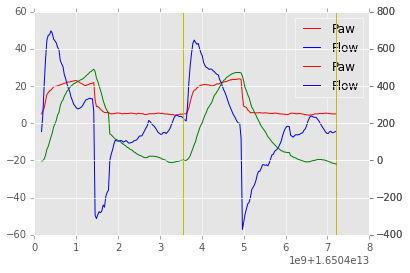

In [31]:
breath_df['validation:raw'] = np.nan

def test_plotter(x):    
    ax1.plot(x['data_frame:Time'], x['data_frame:Paw'], 'r', label='Paw')
    ax1.plot(x['data_frame:Time'], x['data_frame:Flow'], 'b', label='Flow')
    plt.axvline(x=x['data_frame:Time'][-1], color='y')
    ax2 = ax1.twinx()
    ax2.plot(x['data_frame:Time'], x['data_frame:Volume'], 'g', label='Vol')
    plt.ylim((-400, 800))

#at breath 3000
for i in range(0, 10):
    if breath_df['analysis:couplet'].iloc[i] == False and breath_df['breath_number'].iloc[i] + 1 == breath_df['breath_number'].iloc[i+1]:
        fig, ax1 = plt.subplots()
        
        if breath_df['breath_number'].iloc[i] - 1 == breath_df['breath_number'].iloc[i-1]:
            breath_df.iloc[i-1:i+2].apply(test_plotter, axis=1)
        else:
            breath_df.iloc[i:i+2].apply(test_plotter, axis=1)
        ax1.legend()

        plt.title(str(i) + ', '+ breath_df['patientID'].iloc[i] + ', ' + str(breath_df['breath_number'].iloc[i]).split(', ') + ' '+ str(breath_df['breath_number'].iloc[i+1]))
        plt.show()
        
        a = []
        while not set(str(a).split(', ')).issubset(set(['ds', 'fl', 'pl', 'ie', 'pvt', 'pds', 'dvt', 'o', 'g', 'stop', 'n'])):
            a = input('Enter ds (double stacked), fl (flow limited), pl (pressure limited), ie (ineffective trigger), pvt (premi vent termination), dvt (delayed vent termination), o (other), g (garbage), or n (normal) seperated by commas: ')
        
        if a == 'stop': break
        else:
            breath_df['validation:raw'].iloc[i] = str(a).split(', ')
            test_data.update_one({'_id':breath_df['_id'].iloc[i]}, {'$set':{'validation.raw':a}})
        plt.clf()
        fig.clear()
        display.clear_output()

## Sensitivity and Specificity

In [84]:
test = test_data.find({'validation.raw':{'$exists':1}}, 
             {'_id': 1, 'validation':1, 'analysis':1, 'data_frame':1, 'breath_number':1})
test_df = pd.DataFrame(list(test))

In [85]:
test_df = unpack(test_df, unpack_col=['analysis', 'data_frame', 'validation'])
test_df.columns

Index(['_id', 'breath_number', 'analysis:ds_sens', 'analysis:ds', 'analysis:pvt', 'analysis:pds', 'analysis:ie', 'analysis:ds_spec', 'analysis:fl', 'analysis:ds_mid', 'analysis:couplet', 'analysis:pl', 'data_frame:Status', 'data_frame:Time', 'data_frame:Flow', 'data_frame:Paw', 'data_frame:DateTime', 'data_frame:Volume', 'validation:raw'], dtype='object')

In [86]:
headings = ['ds', 'pl', 'fl', 'ie', 'pvt' , 'dvt', 'normal']
for items in headings:
    test_df['validation.'+ items] = test_df['validation:raw'].apply(lambda x: True if (items in x) else False)
    
test_df['validation.normal'] = test_df.apply(lambda x: True if x['validation:raw'] == 'n' else False, axis=1)

def t(x):
    if x['analysis:pl'] == False and x['analysis:ds_spec']== False and x['analysis:ie']== False and x['analysis:pvt']== False and x[ 'analysis:fl']== False :
        return True
    else:
        return False
test_df['analysis:normal'] = test_df.apply(t, axis=1) 

In [87]:
test_df['analysis:normal'].value_counts()

False    970
True     834
dtype: int64

In [88]:
heading = ''

def sens_spec(test_df, true_df):
    if test_df.shape == true_df.shape:
            tot_df = pd.concat([test_df, true_df], axis=1)
            tot_df.rename(columns={tot_df.columns[0]:'test',tot_df.columns[1]:'true'}, inplace=True)
            tot_df['true_true'] = tot_df.apply(lambda x:True if x['true'] and x['test'] else False, axis=1)
            tot_df['false_false'] = tot_df.apply(lambda x: True if ((not x['true']) and (not x['test'])) else False, axis=1)
            
            condition = tot_df['true'].value_counts()
            test = tot_df['test'].value_counts()
            true_pos = tot_df['true_true'].value_counts()[True]
            false_neg = condition[True] - true_pos
            true_neg = tot_df['false_false'].value_counts()[True]
            false_pos = condition[False] - true_neg
            
            print('   ', condition[True], condition[False])
            print(test[True], true_pos, false_pos)
            print(test[False], false_neg, true_neg)
            
            print('Sensitivity', true_pos/condition[True])
            print('Specifity', true_neg/condition[False])


for items in headings:  
    if items == 'ds':
        print('ds')
        sens_spec(test_df['analysis:ds_spec'], test_df['validation.ds'])
        sens_spec(test_df['analysis:ds_mid'], test_df['validation.ds'])
        sens_spec(test_df['analysis:ds_sens'], test_df['validation.ds'])
    elif items == 'dvt':
        pass
    else:
        print(items)
        sens_spec(test_df['analysis:'+items], test_df['validation.'+items])
    print('\n')

ds
    212 1592
203 191 12
1601 21 1580
Sensitivity 0.900943396226
Specifity 0.992462311558
    212 1592
210 197 13
1594 15 1579
Sensitivity 0.929245283019
Specifity 0.991834170854
    212 1592
214 197 17
1590 15 1575
Sensitivity 0.929245283019
Specifity 0.98932160804


pl
    299 1505
402 230 172
1402 69 1333
Sensitivity 0.769230769231
Specifity 0.885714285714


fl
    403 1401
383 342 41
1421 61 1360
Sensitivity 0.848635235732
Specifity 0.970735189151


ie
    182 1622
343 167 176
1461 15 1446
Sensitivity 0.917582417582
Specifity 0.891491985203


pvt
    227 1577
356 205 151
1448 22 1426
Sensitivity 0.903083700441
Specifity 0.90424857324




normal
    946 858
834 781 53
970 165 805
Sensitivity 0.825581395349
Specifity 0.938228438228




0      None
7      None
9      None
84     True
90     True
116    None
125    None
130    None
133    None
146    None
151    None
153    None
176    True
180    None
182    None
184    True
191    None
205    None
212    None
233    None
243    True
244    None
248    True
250    True
254    None
269    None
270    None
290    None
291    None
331    None
333    None
339    None
340    None
349    True
352    None
375    None
376    None
384    None
393    None
410    None
415    True
418    True
424    None
433    None
436    None
443    None
445    None
448    None
451    None
472    None
dtype: object

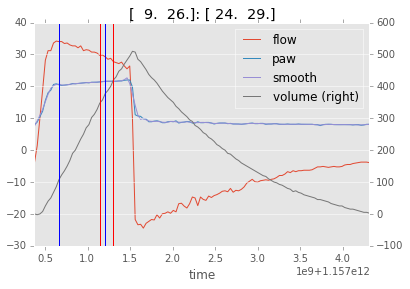

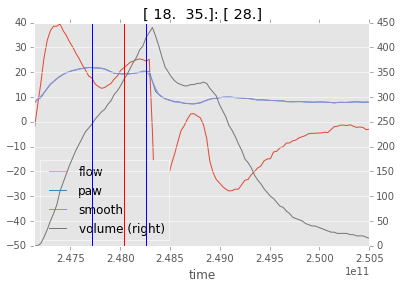

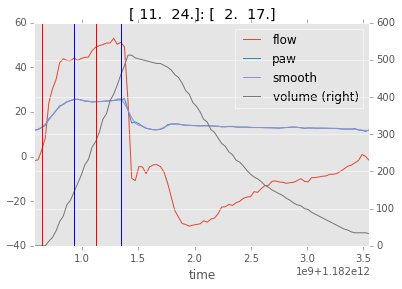

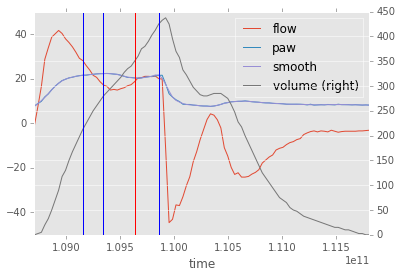

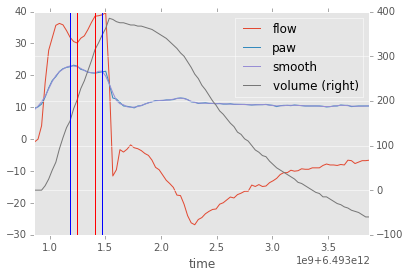

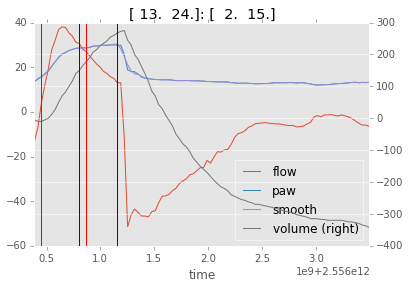

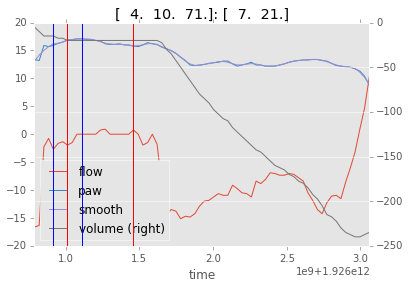

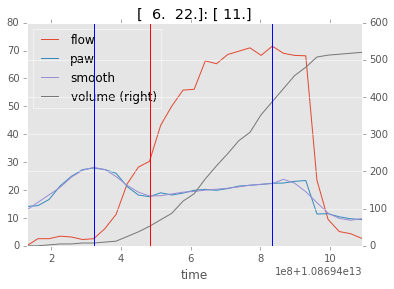

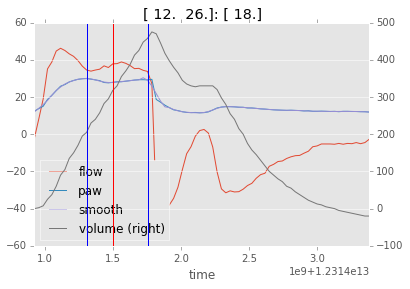

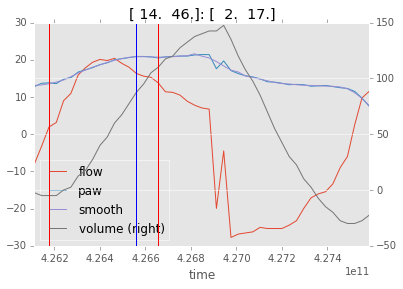

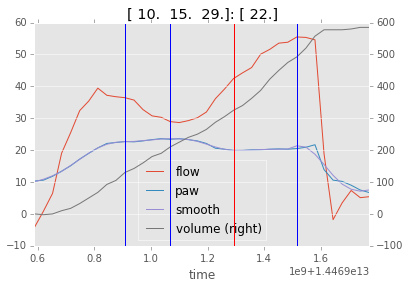

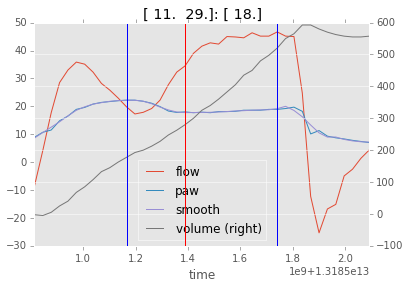

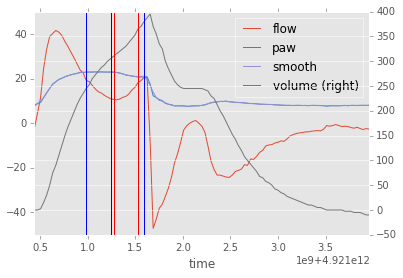

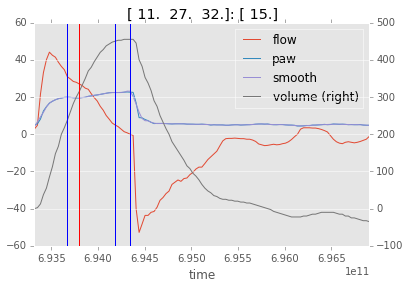

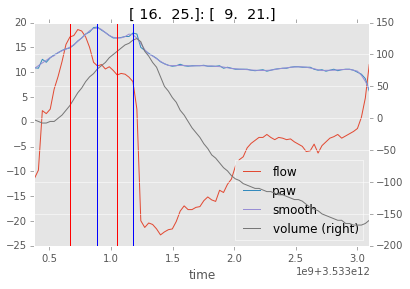

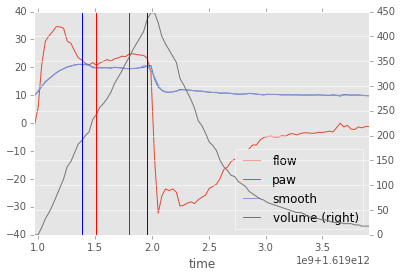

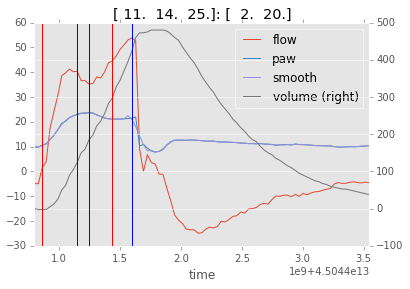

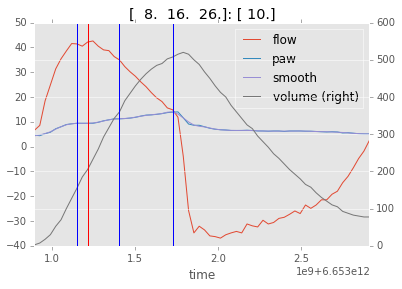

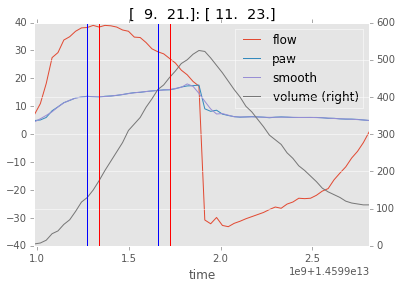

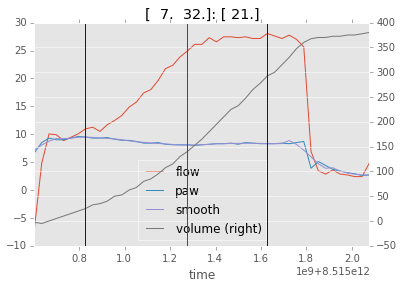

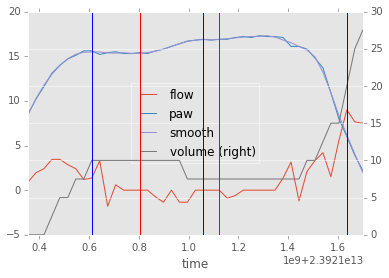

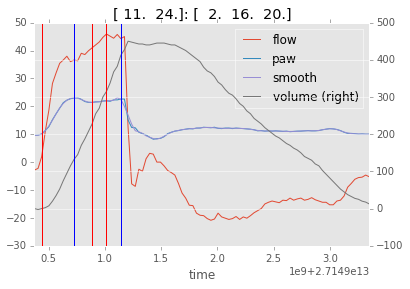

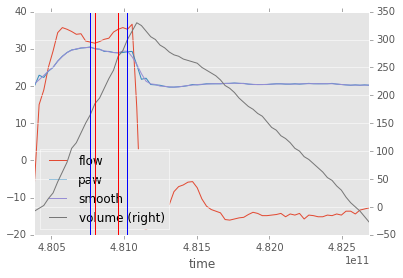

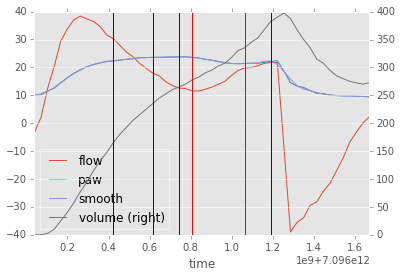

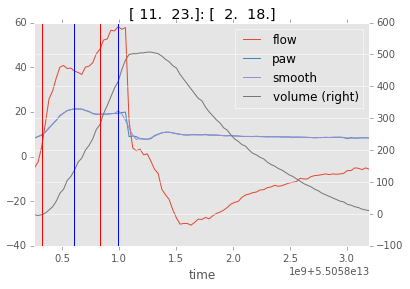

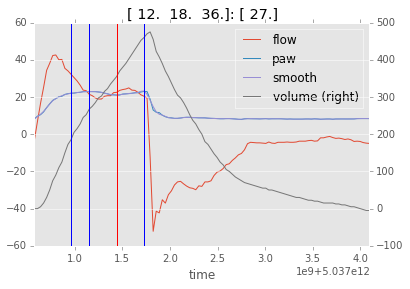

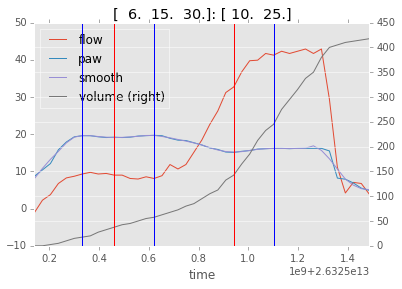

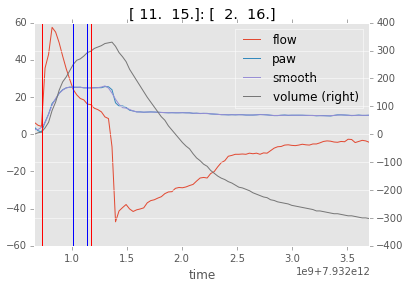

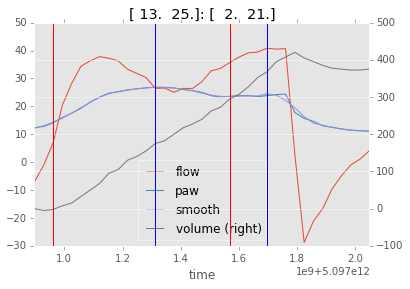

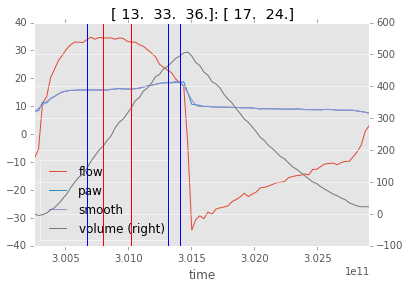

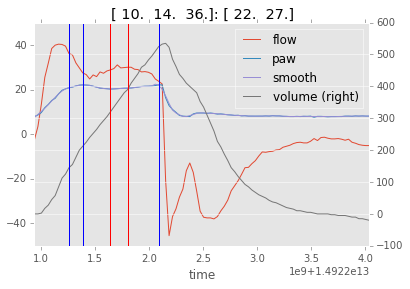

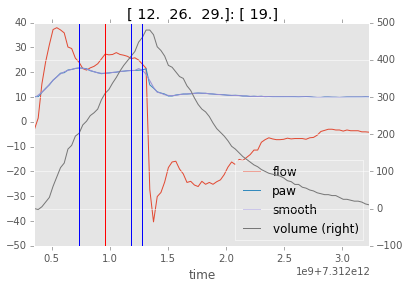

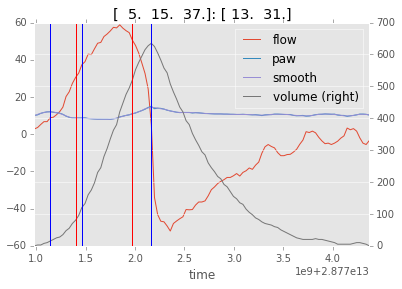

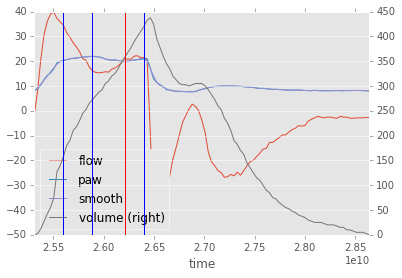

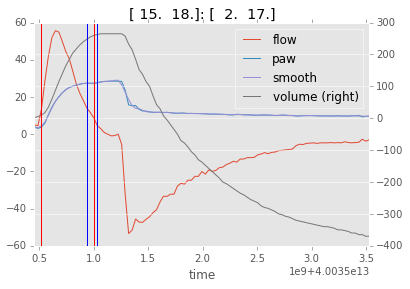

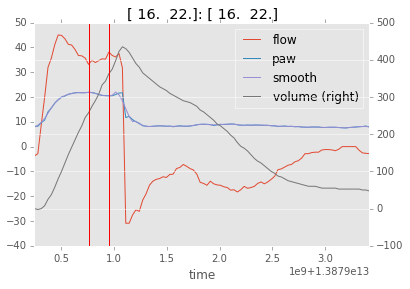

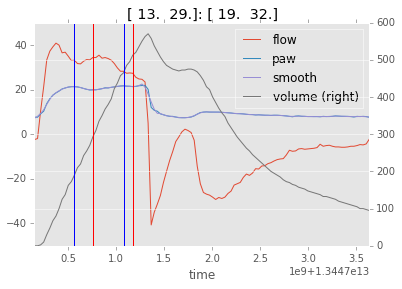

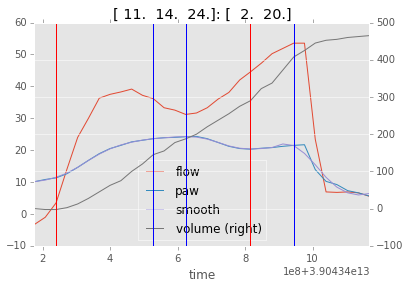

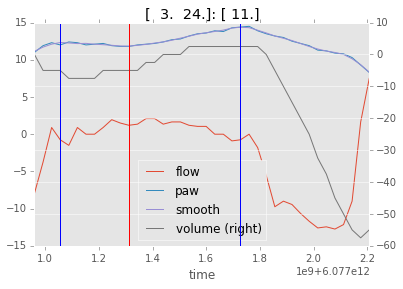

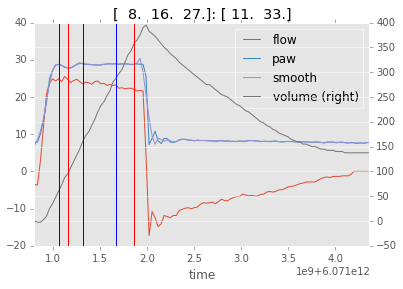

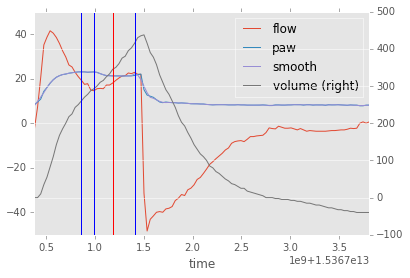

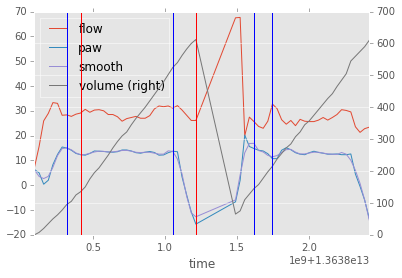

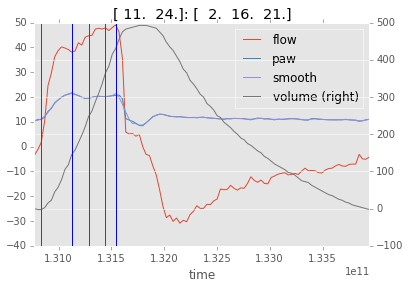

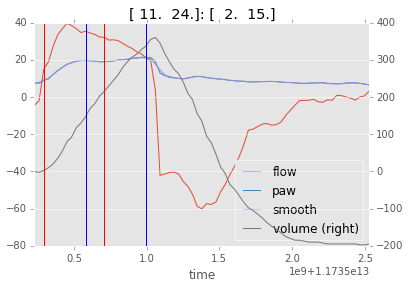

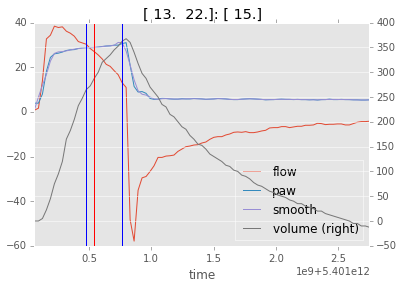

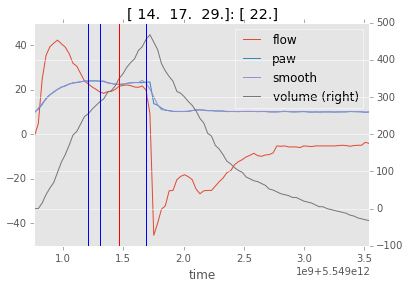

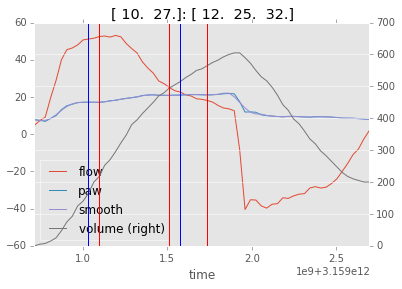

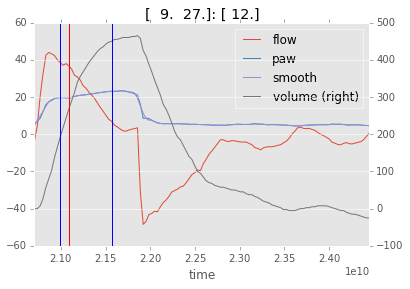

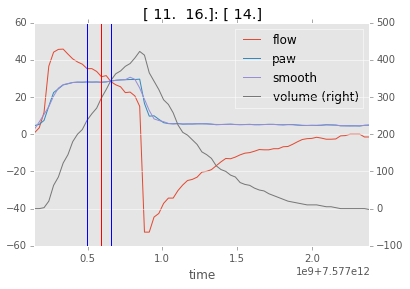

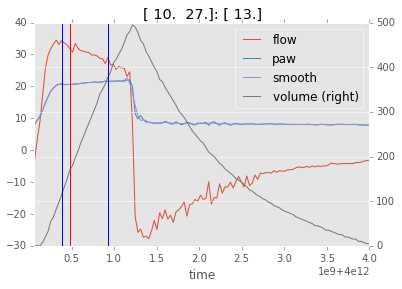

In [97]:
n_max_size = []
n_min_size = []
n_diff = []
n_first_per = []
n_second_per = []

def review(row):
    analysis_df = make_analysis_df(row, p_or_f='paw')
    n_max = np.array([])
    n_min = np.array([])
    
    exp_start = analysis_df[analysis_df.status == 1].shape[0]
    
    analysis_df['diff1'] = analysis_df['smooth'].diff()
    analysis_df['diff2'] = analysis_df['diff1'].diff()
    
    concave_down_index = np.ravel(np.argwhere(analysis_df['diff2'].values < 0))
    concave_up_index = np.ravel(np.argwhere(analysis_df['diff2'].values > 0))
            
    n_max = max_min(concave_down_index, analysis_df, 'max')
    n_min = max_min(concave_up_index, analysis_df, 'min')

    n_max = n_max[n_max <= exp_start+3]
    n_min = n_min[(n_min >= int(exp_start*0.1)) & (n_min <= exp_start-1)]

    if n_max.size == 0 or n_min.size == 0:
        return False
    
    if n_max[-1]/exp_start < 0.75:
        n_max = np.append(n_max, np.argmax(analysis_df[p_or_f].values[int(exp_start*0.75):])+int(exp_start*0.75))
    if n_min[0]/exp_start > 0.8:
        new_min = np.argmin(analysis_df[p_or_f].values[int(exp_start*0.25):int(exp_start*0.75)])+int(exp_start*0.25)
        n_min = np.append(np.array(new_min), n_min)
    
    ps = 0.25
    ptp = 1.025
    if (n_max.size >= 2) and (n_min.size >= 1):
        if n_max[0] < n_min[-1] < n_max[-1]:
            if (n_max[-1] - n_max[0])/exp_start > ps:
                if analysis_df['smooth'].iloc[n_max[0]] > 5 and analysis_df['smooth'].iloc[n_max[-1]] > 5:
                    if (analysis_df[p_or_f].iloc[n_min[-1]] * ptp < analysis_df[p_or_f].iloc[n_max[0]]) or (analysis_df[p_or_f].iloc[n_min[-1]] * ptp < analysis_df[p_or_f].iloc[n_max[-1]]): 
                        if (analysis_df[p_or_f].iloc[n_min[-1]] <= analysis_df[p_or_f].iloc[n_max[0]]) and (analysis_df[p_or_f].iloc[n_min[-1]] <= analysis_df[p_or_f].iloc[n_max[-1]]):
                            #print(n_max[0], n_min[0], n_max[-1])
                            #print(analysis_df[p_or_f].iloc[n_max[0]], analysis_df[p_or_f].iloc[n_min[0]], analysis_df[p_or_f].iloc[n_max[-1]])
                            plotted(analysis_df, n_max, n_min)
                            return True
        if n_max[0] < n_min[0] < n_max[1]:
            if (n_max[1] - n_max[0])/exp_start > ps:
                if analysis_df['smooth'].iloc[n_max[0]] > 5 and analysis_df['smooth'].iloc[n_max[1]] > 5:
                    if (analysis_df[p_or_f].iloc[n_min[0]] * ptp < analysis_df[p_or_f].iloc[n_max[0]]) or (analysis_df[p_or_f].iloc[n_min[0]] * ptp < analysis_df[p_or_f].iloc[n_max[1]]): 
                        if (analysis_df[p_or_f].iloc[n_min[0]] <= analysis_df[p_or_f].iloc[n_max[0]]) and (analysis_df[p_or_f].iloc[n_min[0]] <= analysis_df[p_or_f].iloc[n_max[1]]):
                            #print(n_max[0], n_min[0], n_max[-1])
                            #print(analysis_df[p_or_f].iloc[n_max[0]], analysis_df[p_or_f].iloc[n_min[0]], analysis_df[p_or_f].iloc[n_max[-1]])
                            plotted(analysis_df, n_max, n_min)
                            return True
                        
                      

    # Find Late Peaks
    if n_max.size == 1 and n_max/exp_start > 0.6 and p_or_f == 'flow':
        if np.less(analysis_df['diff1'].values[:exp_start], 7).all():
            plotted(analysis_df, n_max, n_min)
            #print(derivated)
            return True

    # Find if No Sustained Rise
    if np.average(analysis_df[analysis_df.status ==1][p_or_f]) < np.average(analysis_df[analysis_df.status ==0][p_or_f]):
        plotted(analysis_df, n_max, n_min)
        return True  
    
    plotted(analysis_df, n_max, n_min)
    plt.title(str(n_max) + ': '+ str(n_min))
    

 
    pred = []
    for items in ['analysis:ds_mid', 'analysis:ds_sens', 'analysis:ie', 'analysis:pvt', 'analysis:pl', 'analysis:pds', 'analysis:fl', 'analysis:ds_spec']:
            if row[items] == True: pred.append(items)
            
    return

test_df[(test_df['analysis:pl'] == True) & (test_df['validation.pl'] == False)][0:50].apply(review, axis=1)


In [310]:
def clean_up(row):
    def test_plotter(x):    
        ax1.plot(x['data_frame:Time'], x['data_frame:Paw'], 'r', label='Paw')
        ax1.plot(x['data_frame:Time'], x['data_frame:Flow'], 'b', label='Flow')
        plt.axvline(x=x['data_frame:Time'][-1], color='y')
        ax2 = ax1.twinx()
        ax2.plot(x['data_frame:Time'], x['data_frame:Volume'], 'g', label='Vol')
        plt.ylim((-400, 800))

    fig, ax1 = plt.subplots()
    ax1.legend()
    plt.title(str(row['validation:raw']))
    test_plotter(row)
    plt.show()

    a = []
    while not set(str(a).split(', ')).issubset(set(['ds', 'fl', 'pl', 'ie', 'pvt', 'pds', 'dvt', 'o', 'g', 'stop', 'n'])):
        a = input('Enter ds (double stacked), fl (flow limited), pl (pressure limited), ie (ineffective trigger), pvt (premi vent termination), dvt (delayed vent termination), o (other), g (garbage), or n (normal) seperated by commas: ')
    
    test_data.update_one({'_id':row['_id']}, {'$set':{'validation.raw':a}})
    plt.clf()
    fig.clear()
    display.clear_output()

#test_df[(test_df['analysis:ie'] == False) & test_df['validation.ie']==True].apply(clean_up, axis=1)

89      None
131     None
146     None
179     None
258     None
280     None
314     None
353     None
391     None
413     None
425     None
473     None
544     None
602     None
671     None
678     None
708     None
728     None
839     None
865     None
933     None
1007    None
1183    None
1242    None
1284    None
1296    None
1330    None
1387    None
1431    None
1450    None
1463    None
1544    None
1633    None
1641    None
1642    None
1693    None
1709    None
1721    None
1722    None
1760    None
1761    None
1773    None
1778    None
1779    None
1795    None
dtype: object